# Disaggregation

Implementation of the best evaluated model in the validation stage, corresponding to the FHMM model trained with average active power data collected every 30 seconds.

Libraries and other adjustments:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.utils import print_dict

plt.style.use('bmh')

labels = ['Main', 'Electric furnace', 'Microwave','Television','Incandescent Lamp','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:red','tab:pink','tab:cyan','tab:gray','tab:grey']


## Training set

In [2]:
test =DataSet('dsualmh_testing.h5')
test_elec = test.buildings[1].elec
test.set_window(start="2023-01-25 10:43:00", end="2023-01-25 12:46:00")  #TODAS LAS MUESTRAS del SEGUNDO DATASET DE PRUEBAS
test_Main=test_elec.mains() #medidor principal de cabecera
test_Main

ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='dsualmh', appliances=[Appliance(type='electric shower heater', instance=1)])
  ElecMeter(instance=9, building=1, dataset='dsualmh', appliances=[Appliance(type='fan', instance=1)]

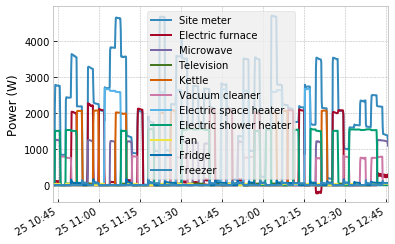

In [4]:
test_elec.plot()

# Original Signal vs Disaggregated Signal Representation

We will use a sampling period = 2s

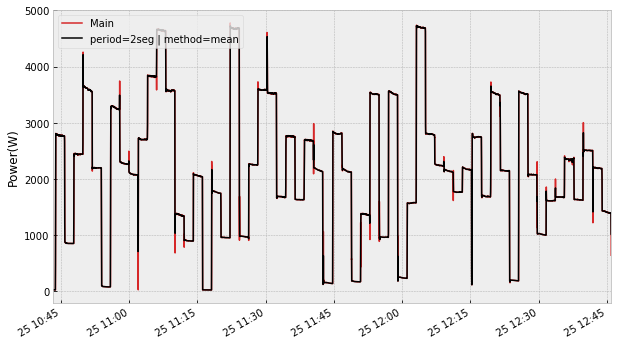

In [5]:
rcParams['figure.figsize'] = (10, 6)

ax1 = next(test_Main.load(ac_type='active', sample_period=1, resample_kwargs={'how':'first'})).plot(c='tab:red', lw=1.5) 
next(test_Main.load(ac_type='active', sample_period=2, resample_kwargs={'how':'mean'})).plot(ax=ax1, c='k', lw=1.5) 

ax1.legend([('Main'),'period=2seg | method=mean'], loc='upper left') #etiquetas
ax1.minorticks_off()   
ax1.set_ylabel('Power(W)')
    
plt.savefig('./data/images/6.1_Plot_test_30seg.svg', bbox_inches='tight', transparent=True)
pass

## Disagregation

In [6]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
from nilmtk import HDFDataStore

train = DataSet('dsualmh.h5')
train.set_window(start="2023-06-09 09:34:00", end="2023-06-09 12:54:00")
train_elec = train.buildings[1].elec
#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
train_Devices


#Set para validación
valid = DataSet('dsualmh.h5')
valid.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")
valid_elec = valid.buildings[1].elec
print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)
print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
print(valid_Devices)



periods = { '1s':1 }
methods = {'first'}
times = {}

data_dir = './data/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo

for sp_name, sp in periods.items():
    t = []
    for method in methods:
        #models={'FHMM':FHMM()}
        models={'CO':CombinatorialOptimisation()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=sp, #cambio de muestreo
                resample_kwargs={'how':method}) #método 

            t.append(round(time.time()-start,2)) #tiempo de simulación
            output=HDFDataStore(data_dir+'NILM/Results/test_results.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t

            
    
print('\n\nDone!')

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='dsualmh', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='dsualmh', appliances=[Appliance(type='electric shower heater', instance=1)])
  El

### Results

In [7]:
data_dir = './data/'
results=DataSet(data_dir+'NILM/Results/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones
results_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='CO', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='CO', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='CO', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='CO', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='CO', appliances=[Appliance(type='incandescent lamp', instance=1)])
  ElecMeter(instance=6, building=1, dataset='CO', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='CO', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='CO', appliances=[Appliance(type='electric shower heater', instance=1)])
  ElecMeter(instance=9, building=1, dataset='CO', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=10, buildin

### Metadata

In [8]:
print_dict(results.metadata)

In [8]:
print_dict(results.buildings[1].metadata)

In [9]:
print_dict(results_elec[1].get_metadata())

## Graphical Analysis


### All Results

11/11 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

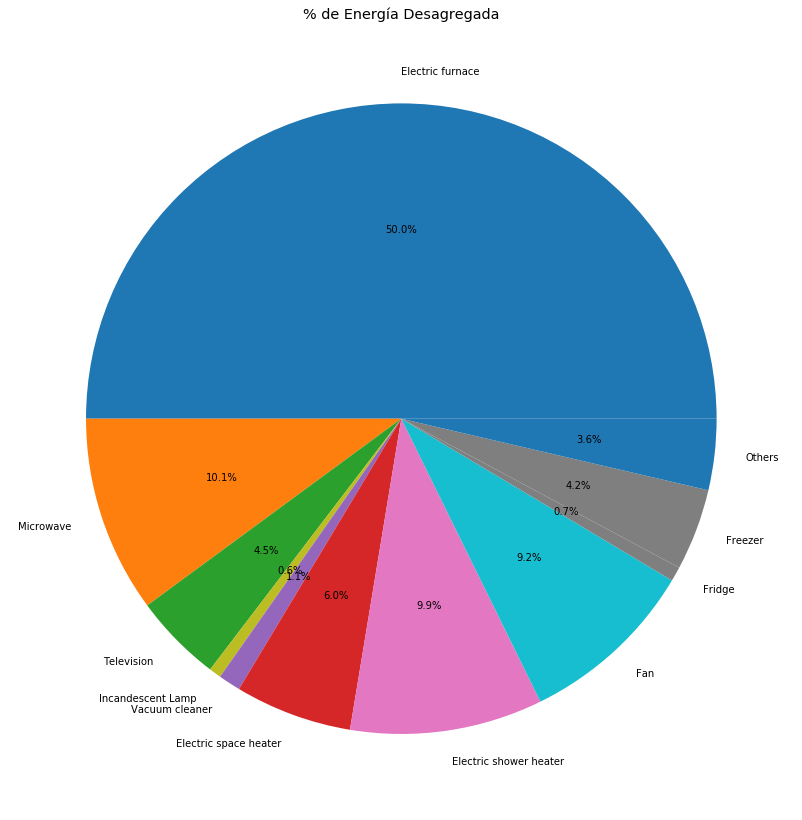

In [10]:
d1=results_elec.fraction_per_meter()
ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie',
            labels=labels[1:]+list(['Others']), figsize=(14.5,14.5),
            colors=colors)
ax1.set(ylabel="")
ax1.set(title='% de Energía Desagregada')
#guarda gráfico
plt.savefig('./data/images/6.2_Plot_results_1.1.svg', bbox_inches='tight', transparent=True)

## COMPARISON OF THE TEST SET WITH PREDICTED DATA

CORRECT GRAPH BUT WITHOUT LABELS

The test set is compared with the predictions and is consistent

10/10 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])=1)])

[Text(0.5, 1.0, 'Pred')]

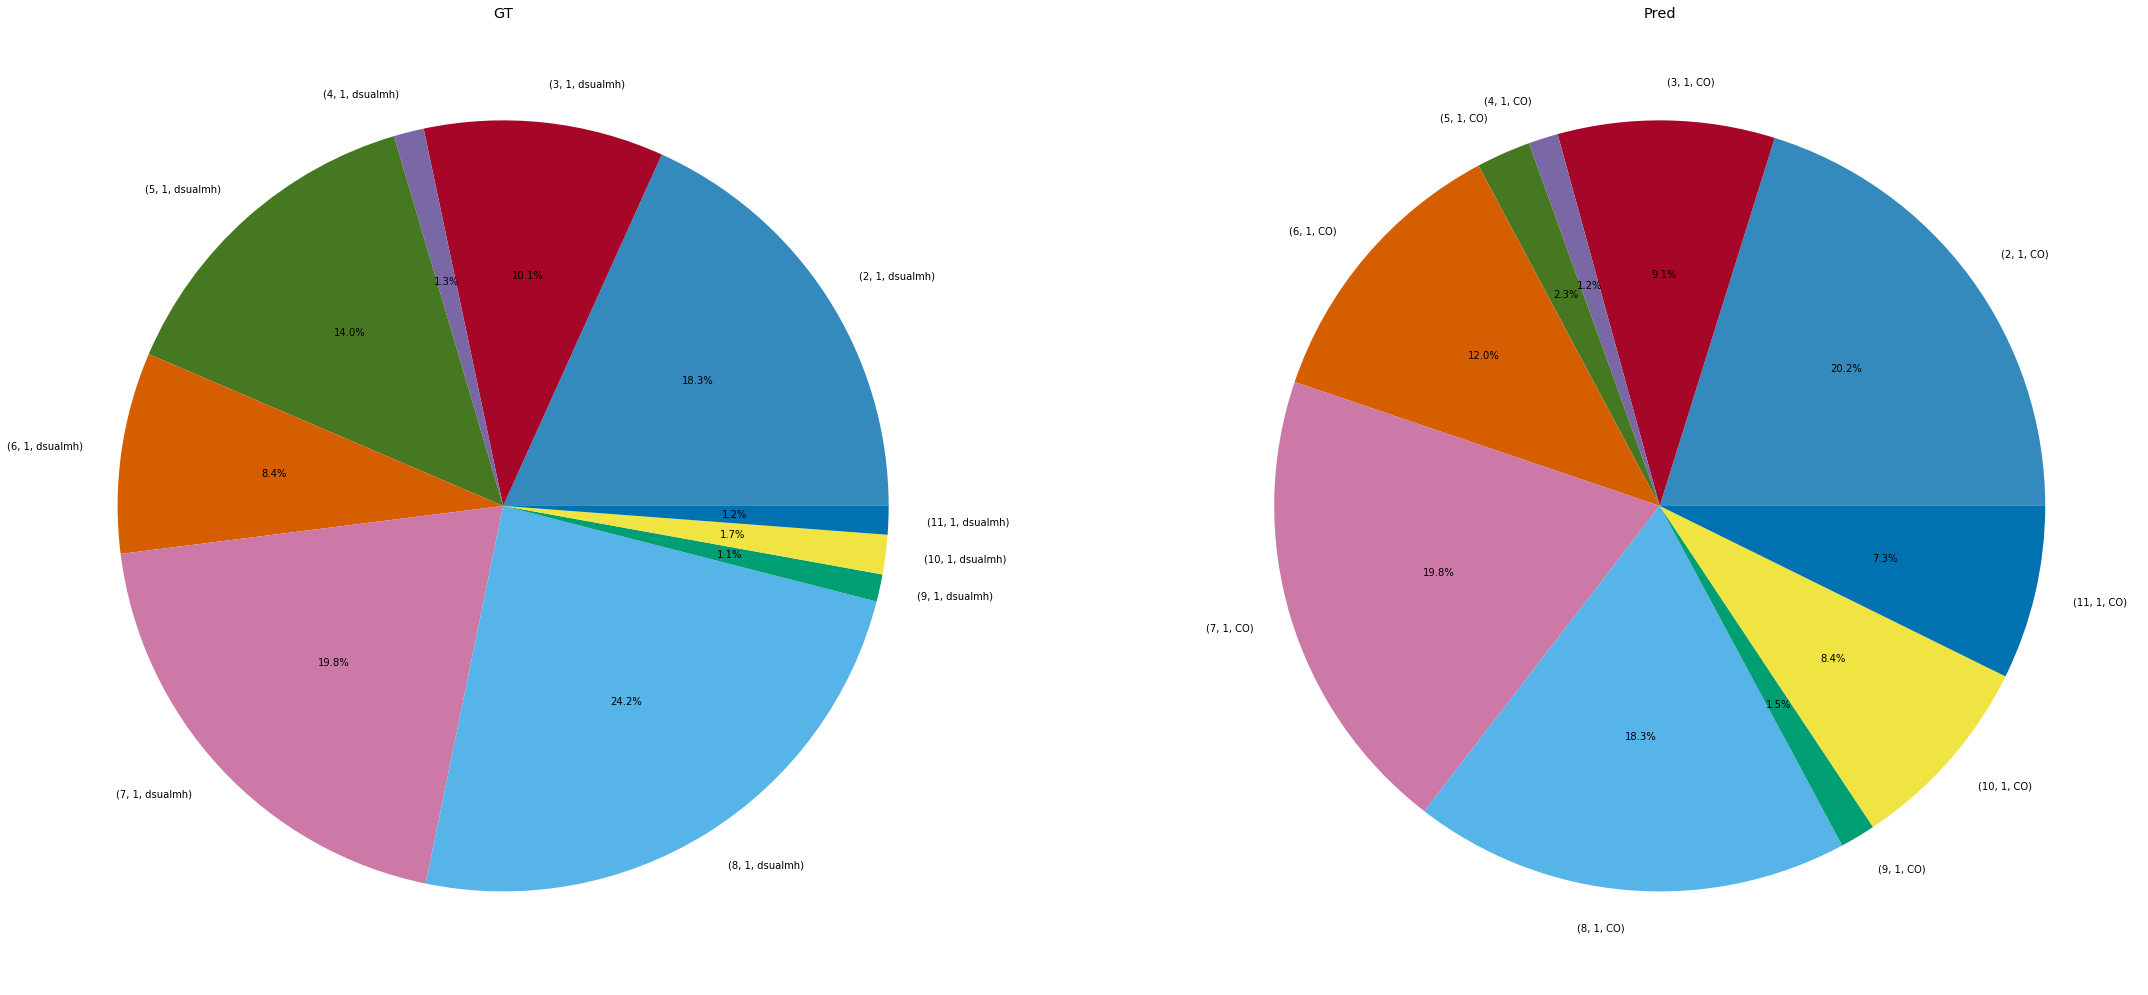

In [12]:
rcParams['figure.figsize'] = (38, 35)
fig, (ax1, ax2) = plt.subplots(1, 2)

#estos la verdad ( conjunto de pruebas)
test_elec.select(instance=[2,3,4,5,6,7,8,9,10,11]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')

#la prediccion
results_elec.select(instance=[2,3,4,5,6,7,8,9,10,11]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')

ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

Comparison of the validation set with predictions from the best model (WITHOUT LABELS)

10/10 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])=1)])

[Text(0.5, 1.0, 'Pred')]

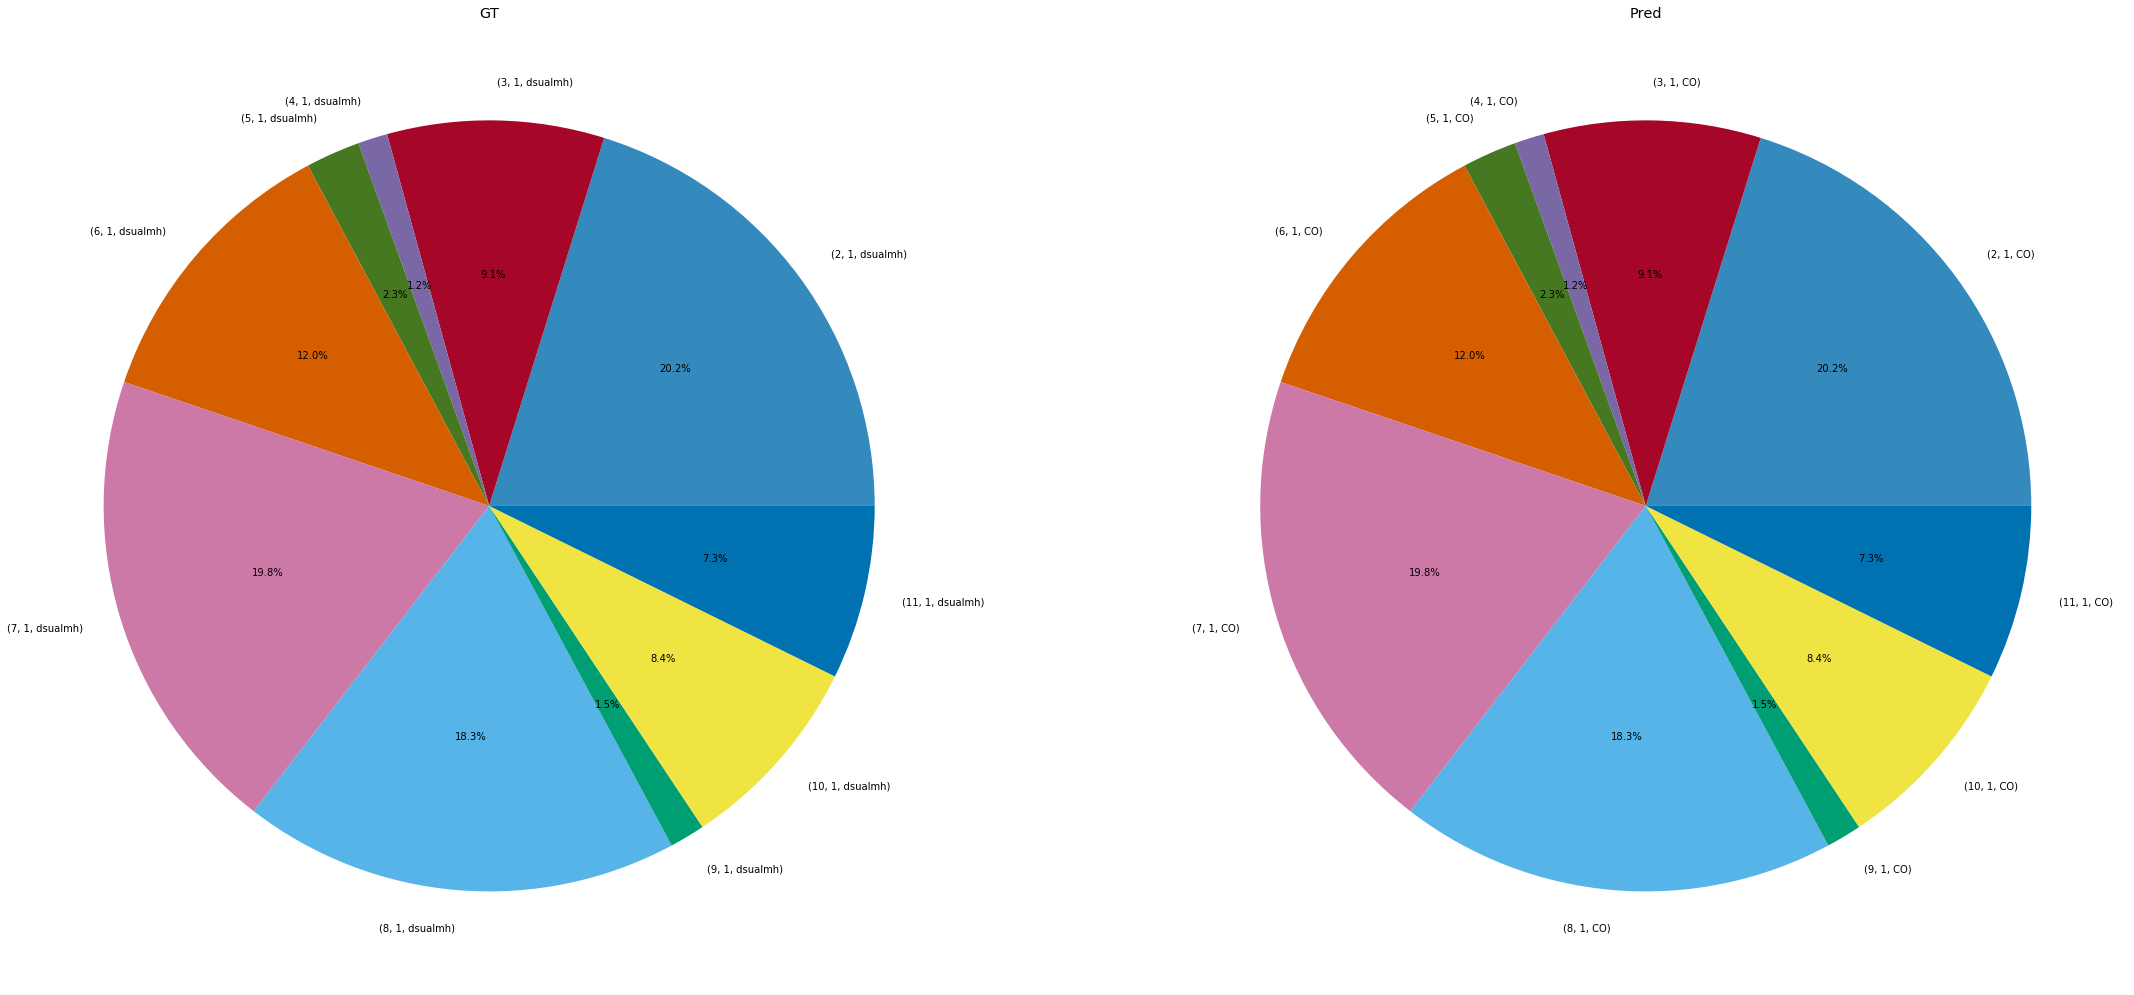

In [13]:
#Set para validación
valid = DataSet('dsualmh.h5') 
valid.set_window(start="2023-06-09 12:55:00", end="2023-06-09 13:36:00")
#valid.set_window(start="2023-06-09 13:17:00", end="2023-06-09 13:36:00")
valid_elec = valid.buildings[1].elec

#predicciones
results=DataSet(data_dir+'NILM/Results/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones


rcParams['figure.figsize'] = (38, 35)
fig, (ax1, ax2) = plt.subplots(1, 2)

#Las medidas
valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')

#la prediccion
results_elec.select(instance=[2,3,4,5,6,7,8,9,10,11]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')

ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

### Comparison of test set (GT) with predictions including labels

1/10 ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='electric furnace', instance=1)])

10/10 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])=1)])

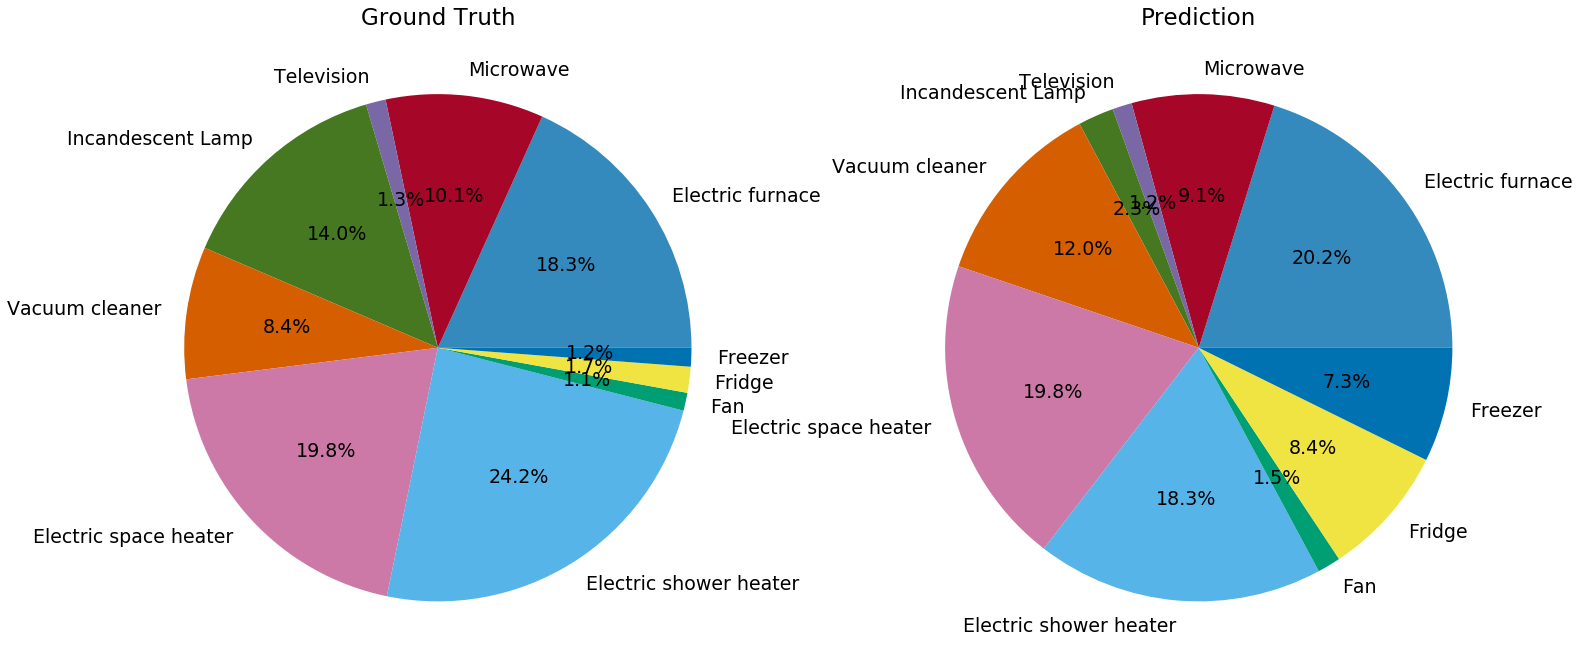

In [29]:
labels = ['Main', 'Electric furnace', 'Microwave', 'Television', 'Incandescent Lamp', 'Vacuum cleaner', 'Electric space heater',
          'Electric shower heater', 'Fan', 'Fridge', 'Freezer']



rcParams['figure.figsize'] = (25, 22)
fig, (ax1, ax2) = plt.subplots(1, 2)
#estos la verdad del conjunto de pruebas
test_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).fraction_per_meter().plot(
    ax=ax1, autopct=lambda p: '{:.1f}%'.format(p), kind='pie', labels=labels[1:],fontsize=19)
#la prediccion
results_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).fraction_per_meter().plot(
    ax=ax2, autopct=lambda p: '{:.1f}%'.format(p), kind='pie', labels=labels[1:],fontsize=19)
#ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie', labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),  colors=colors)

# Añadir etiquetas personalizadas
#ax1.legend(labels=labels[1:], loc="upper right", fontsize=22)
#ax2.legend(labels=labels[1:], loc="upper right", fontsize=22)


#titulos 
ax1.set(ylabel="")
ax1.set_title('Ground Truth',fontsize = 23)
ax2.set(ylabel="")
ax2.set_title('Prediction',fontsize = 23)

plt.savefig('./data/images/test_vs_predic.svg', bbox_inches='tight', transparent=True)
plt.show()

10/10 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])=1)])

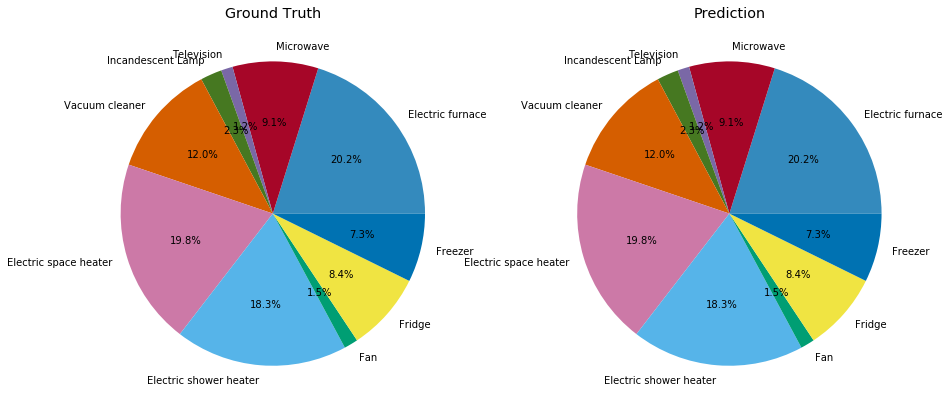

In [15]:
labels = ['Main', 'Electric furnace', 'Microwave', 'Television', 'Incandescent Lamp', 'Vacuum cleaner', 'Electric space heater',
          'Electric shower heater', 'Fan', 'Fridge', 'Freezer']


rcParams['figure.figsize'] = (15, 12)
fig, (ax1, ax2) = plt.subplots(1, 2)
#estos la verdad del conjunto de validacion
valid_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).fraction_per_meter().plot(
    ax=ax1, autopct=lambda p: '{:.1f}%'.format(p), kind='pie', labels=labels[1:])
#la prediccion
results_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).fraction_per_meter().plot(
    ax=ax2, autopct=lambda p: '{:.1f}%'.format(p), kind='pie', labels=labels[1:])
#ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie', labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),  colors=colors)
ax1.set(ylabel="")
ax1.set(title='Ground Truth')
ax2.set(ylabel="")
ax2.set(title='Prediction')
plt.savefig('./data/images/val_vs_predic.svg', bbox_inches='tight', transparent=True)
plt.show()

In [16]:

import numpy as np

# Definir la tabla de resultados
results = np.array([
    [18.3, 17.7, 0.6],
    [10.1, 9, 1.1],
    [1.3, 0.9, 0.4],
    [14, 3.1, 10.9],
    [8.4, 14.4, -6],
    [19.8, 17.3, 2.5],
    [24.2, 20.6, 3.6],
    [1.1, 1.8, -0.7],
    [1.7, 8.3, -6.6],
    [1.2, 6.9, -5.7]
])

# Calcular MAE
mae = np.mean(np.abs(results[:, 0] - results[:, 1]))

# Calcular MSE
mse = np.mean((results[:, 0] - results[:, 1])**2)

# Calcular RMSE
rmse = np.sqrt(mse)

# Calcular R^2
r2 = 1 - np.sum((results[:, 0] - results[:, 1])**2) / np.sum((results[:, 0] - results.mean())**2)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

MAE: 3.81
MSE: 25.229000000000003
RMSE: 5.022847797813507
R^2: 0.6837291877979564


## Trace of Numerical Values

In [17]:



print("Realidad")
valid_elec_data = []

for meter in valid_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).meters:
    # Get the meter data directly
    meter_data = []

    # Extract values from the power_series generator and append to the list
    for power in meter.power_series():
        meter_data.append(power)

    # Sum up the power data
    meter_data = np.sum(meter_data)
    print(meter_data)
    # Append the meter data to the list of data
    valid_elec_data.append(meter_data)

#la prediccion
print("results")

results_elec_data = []
for meter in results_elec.select(instance=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]).meters:
    # Get the meter data directly
    meter_data = []

    # Extract values from the power_series generator and append to the list
    for power in meter.power_series():
        meter_data.append(power)

    # Sum up the power data
    meter_data = np.sum(meter_data)
    print(meter_data)
    # Append the meter data to the list of data
    results_elec_data.append(meter_data)

# Create DataFrames for the ground truth and prediction data
valid_elec_meter_df = pd.DataFrame(valid_elec_data)
results_elec_meter_df = pd.DataFrame(results_elec_data)

# Calculate the total electricity consumption for each meter
valid_elec_total = valid_elec_meter_df.sum()
results_elec_total = results_elec_meter_df.sum()

# Create a bar chart for the ground truth data
ax1.bar(valid_elec_total.index, valid_elec_total.values)
ax1.set(title='GT Total Electricity Consumption')
ax1.set_xlabel('Meter')
ax1.set_ylabel('Electricity Consumption (kWh)')

# Create a bar chart for the prediction data
ax2.bar(results_elec_total.index, results_elec_total.values)
ax2.set(title='Pred Total Electricity Consumption')
ax2.set_xlabel('Meter')
ax2.set_ylabel('Electricity Consumption (kWh)')

# Show the plot
plt.show()

Realidad
1470350.4
454955.94
82959.22
97413.66
204496.72
429871.9
874405.8
58755.555
65471.668
59882.41
results
802472.0
361410.0
49400.0
90686.0
477292.0
785617.0
727837.0
58977.0
333054.0
290010.0


# Disaggregated Consumption Graph

(-100, 3200)

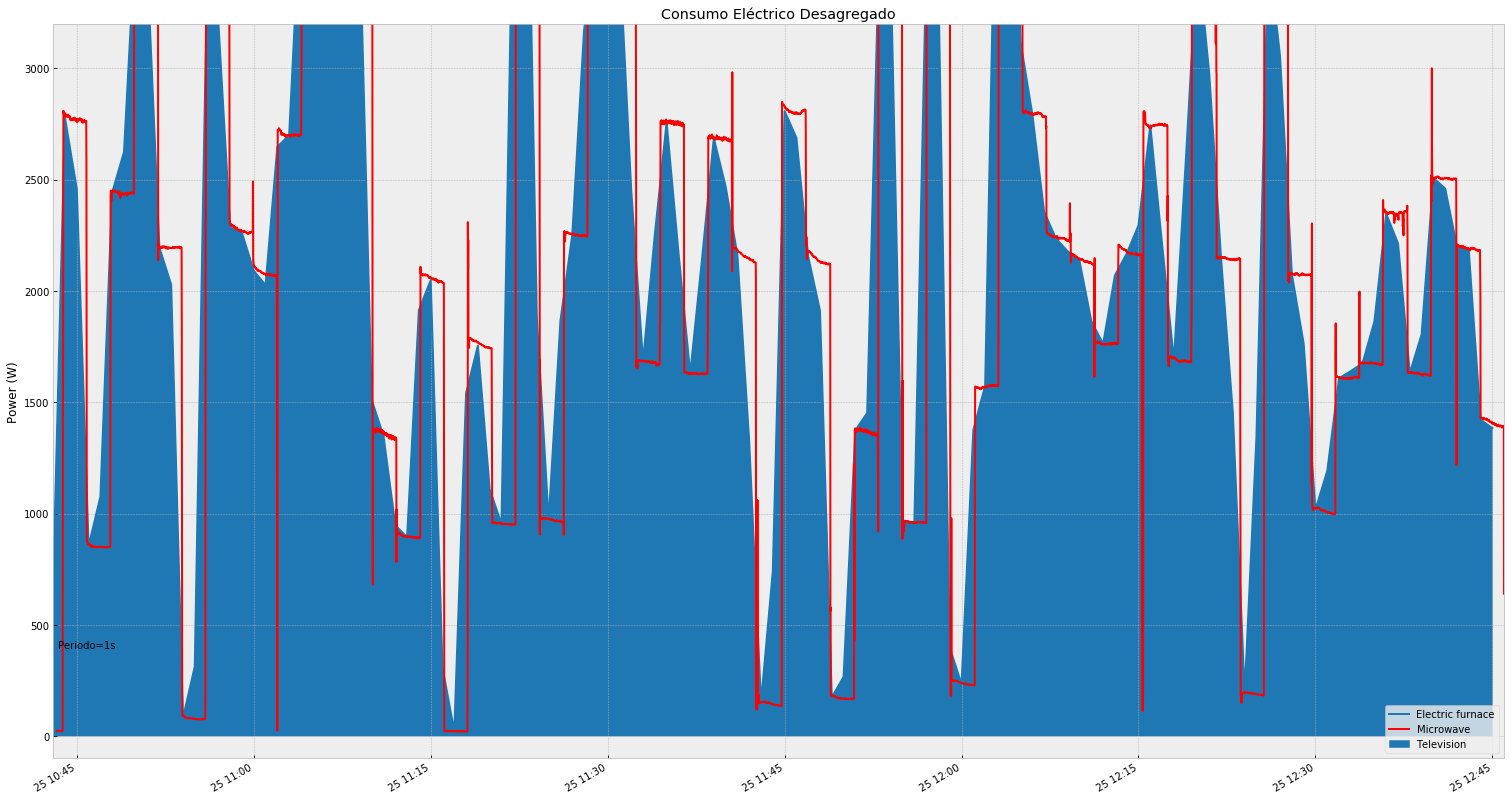

In [18]:
rcParams['figure.figsize'] = (26, 15)

df_d=test_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(test_elec[1].load(ac_type='active')).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:6])
ax1.set(title='Consumo Eléctrico Desagregado')

ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,3200)

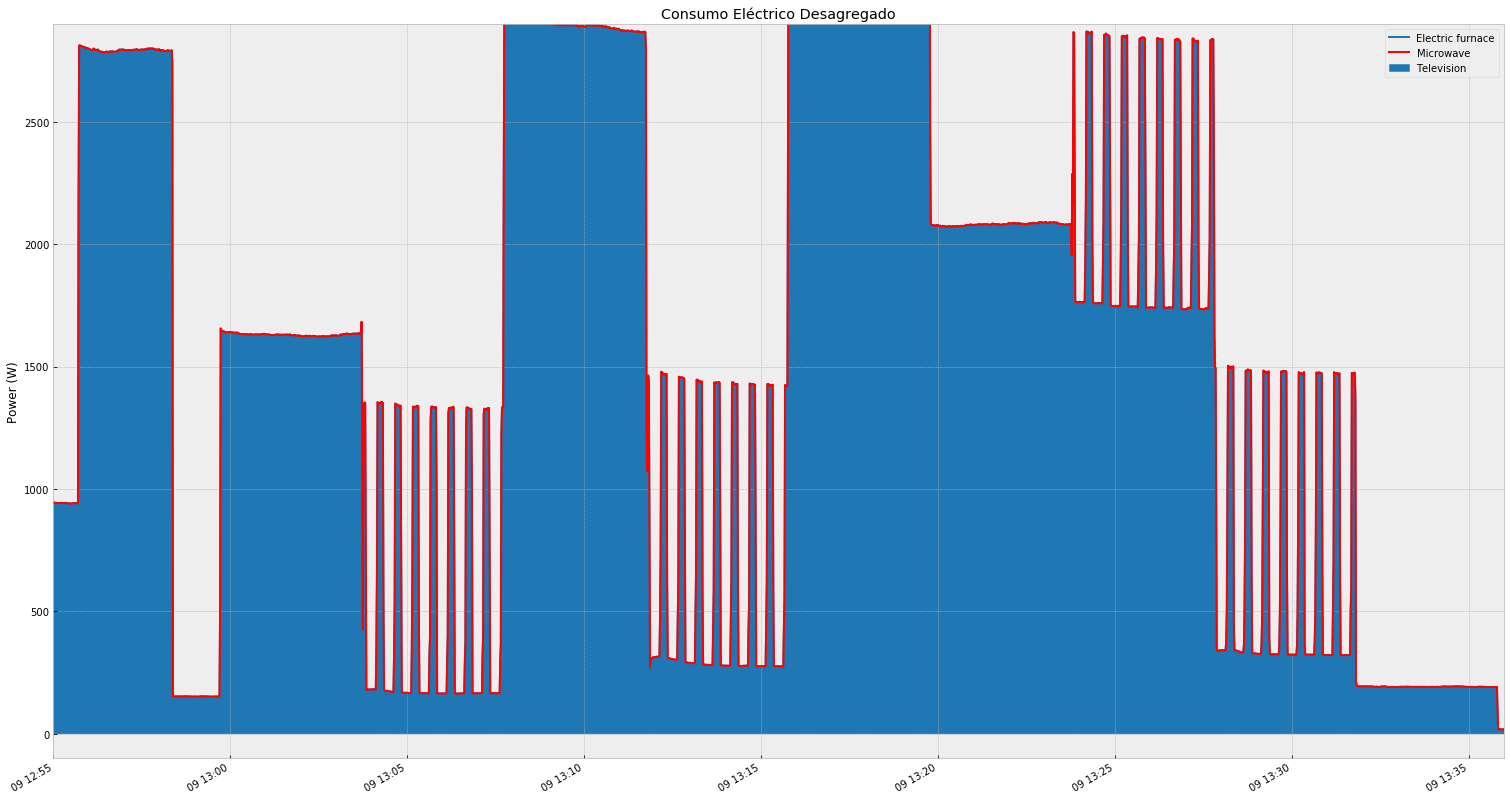

In [19]:
rcParams['figure.figsize'] = (26, 15)

df_d=results_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(results_elec[1].load()).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:12])
ax1.set(title='Consumo Eléctrico Desagregado')

ax1.set(ylabel='Power (W)')
#ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2900)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)
pass

In [20]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Main Principal: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

11/11 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

Energía de Dispositivos:
(2, 1, CO)     0.2
(3, 1, CO)     0.1
(4, 1, CO)     0.0
(5, 1, CO)     0.0
(6, 1, CO)     0.1
(7, 1, CO)     0.2
(8, 1, CO)     0.2
(9, 1, CO)     0.0
(10, 1, CO)    0.1
(11, 1, CO)    0.1
Name: active, dtype: float64

Energía Total Dispositivos: 1.0

Energía Main Principal: 1.1

Energía No medida: 0.10000000000000009


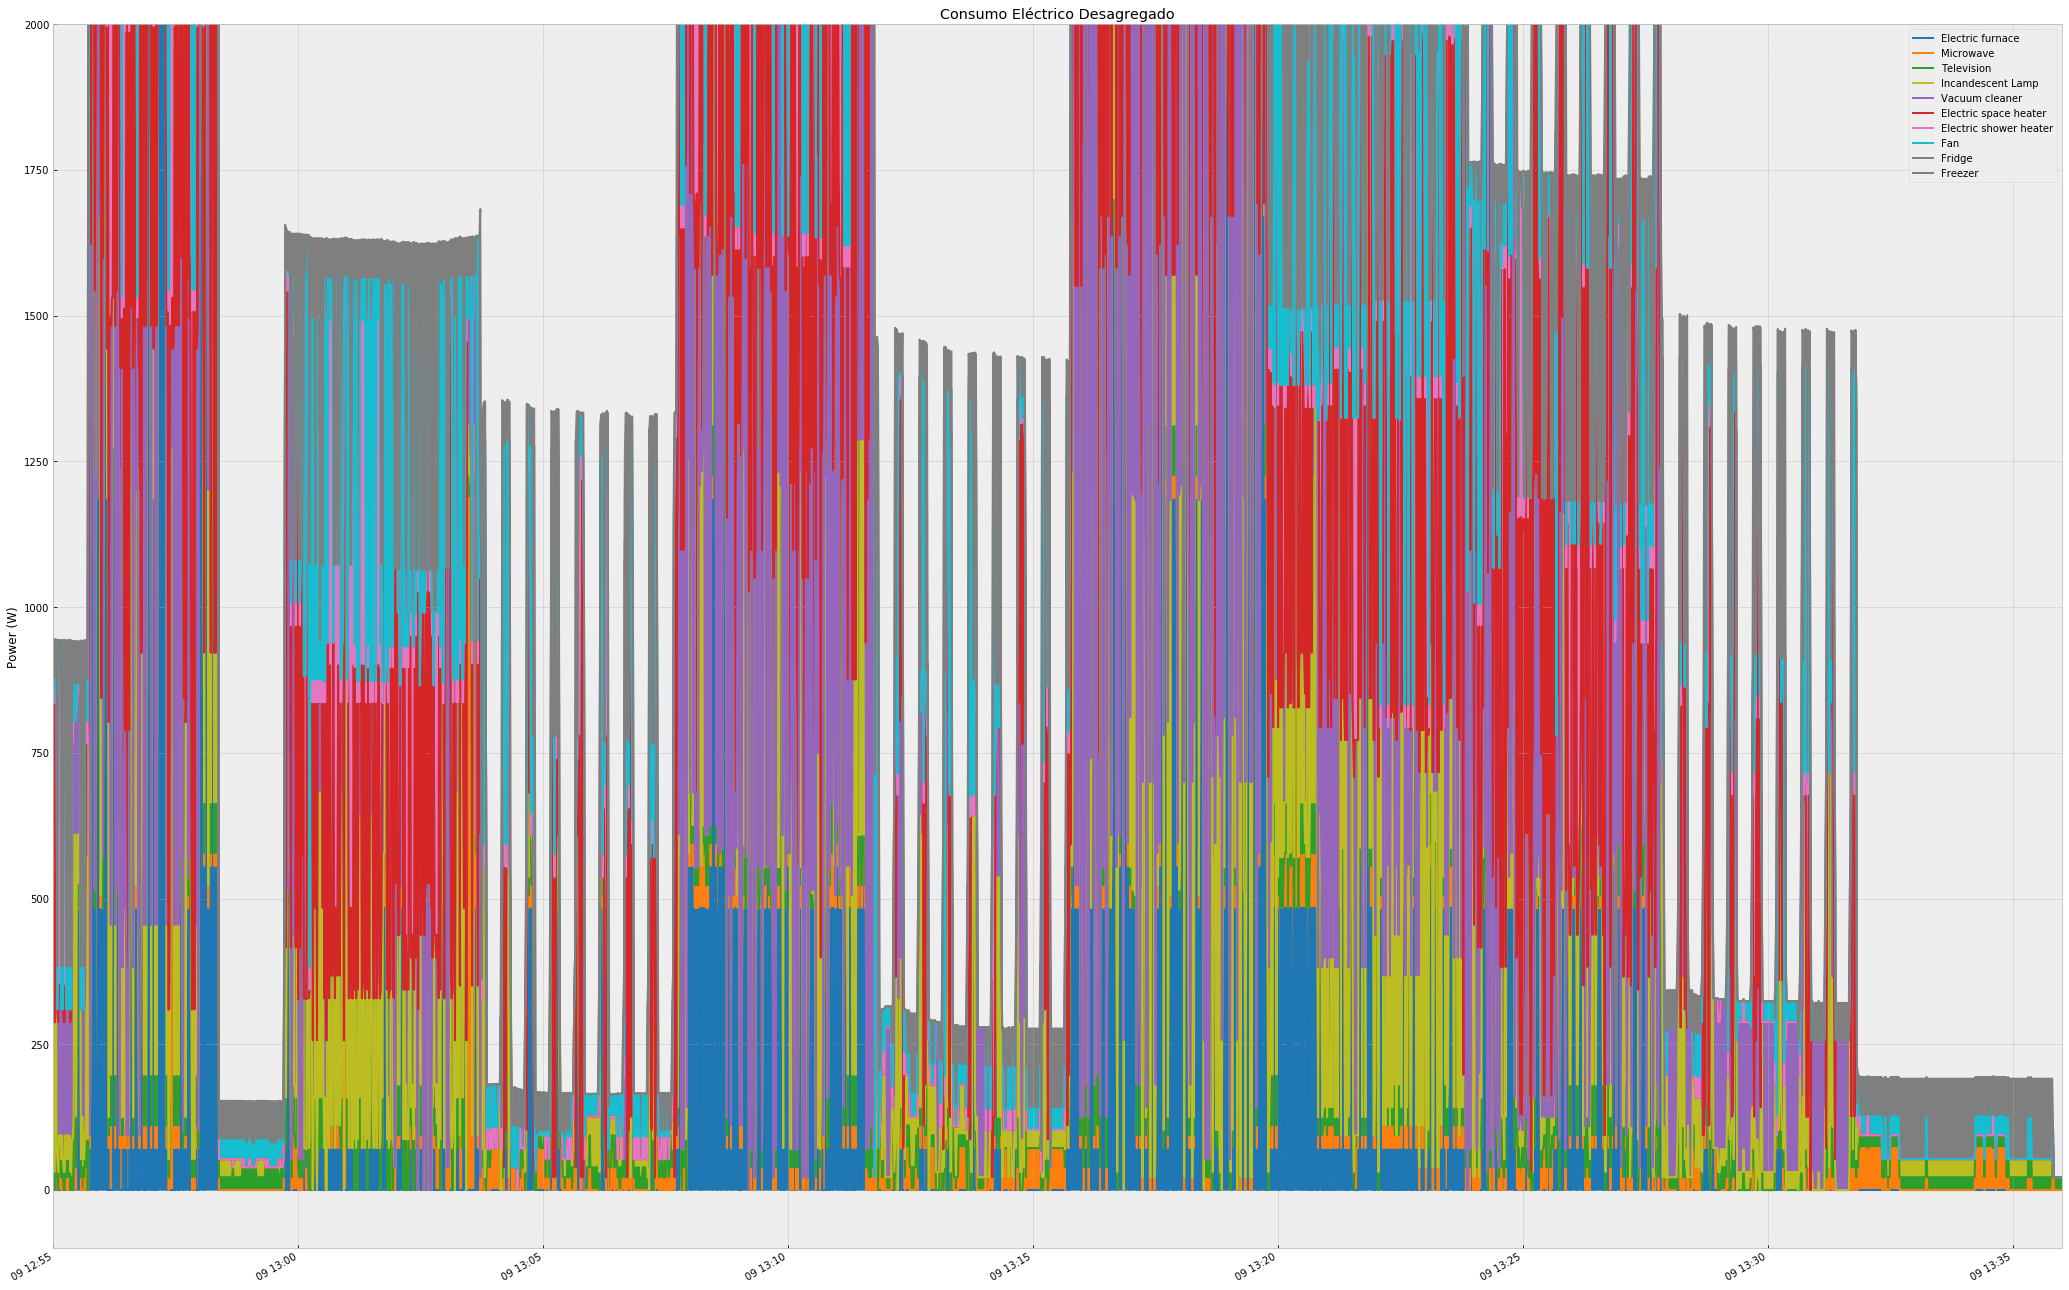

In [21]:
rcParams['figure.figsize'] = (36, 25)

df_d=results_elec.select(instance=[2,3,4,5,6,7,8,9,10,11]).dataframe_of_meters(ac_type='active')

ax1 = df_d.plot(kind='area',color=colors)   
#etiquetas
ax1.legend(labels[1:12])
ax1.set(title='Consumo Eléctrico Desagregado')

ax1.set(ylabel='Power (W)')
#ax1.annotate("Periodo=1s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2000)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)

In [22]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Main Principal: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

11/11 ElecMeter(instance=11, building=1, dataset='CO', appliances=[Appliance(type='freezer', instance=1)])instance=1)])

Energía de Dispositivos:
(2, 1, CO)     0.2
(3, 1, CO)     0.1
(4, 1, CO)     0.0
(5, 1, CO)     0.0
(6, 1, CO)     0.1
(7, 1, CO)     0.2
(8, 1, CO)     0.2
(9, 1, CO)     0.0
(10, 1, CO)    0.1
(11, 1, CO)    0.1
Name: active, dtype: float64

Energía Total Dispositivos: 1.0

Energía Main Principal: 1.1

Energía No medida: 0.10000000000000009


# Disagregation for DSUALM10H

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Datos proporcionados
gt = np.array([0.6, 5, 3.6, 4.4, 86.3])
pred = np.array([1.9, 4.5, 0, 4.5, 89.1])

# Cálculos
mae = mean_absolute_error(gt, pred)
mse = mean_squared_error(gt, pred)
rmse = np.sqrt(mse)
r2 = r2_score(gt, pred)

# Resultados
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 1.6599999999999995
MSE: 4.549999999999997
RMSE: 2.1330729007701534
R^2: 0.9958706697392514


## DEPS

In [24]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Nuevos datos proporcionados
gt_nuevos = np.array([28.5, 17.8, 12.3, 12.3, 9.9, 19.2])
pred_nuevos = np.array([28.3, 17.7, 16.9, 13.7, 4.5, 18.9])

# Cálculos
mae_nuevos = mean_absolute_error(gt_nuevos, pred_nuevos)
mse_nuevos = mean_squared_error(gt_nuevos, pred_nuevos)
rmse_nuevos = np.sqrt(mse_nuevos)
r2_nuevos = r2_score(gt_nuevos, pred_nuevos)

# Resultados
print(f"MAE: {mae_nuevos}")
print(f"MSE: {mse_nuevos}")
print(f"RMSE: {rmse_nuevos}")
print(f"R^2: {r2_nuevos}")

MAE: 1.9999999999999998
MSE: 8.736666666666665
RMSE: 2.9557852876463584
R^2: 0.773713595027052


## DSUALM10H full test period

In [33]:
## DSUALM10H 
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Nuevos datos proporcionados
gt_nuevos = np.array([18.3, 10.1,1.3, 14, 8.4, 19.8, 24.2, 1.1, 1.7, 1.2])
pred_nuevos = np.array([17.7, 9, 0.9, 3.1, 14.4, 17.3, 20.6, 1.8, 8.3, 6.9])

# Cálculos
mae_nuevos = mean_absolute_error(gt_nuevos, pred_nuevos)
mse_nuevos = mean_squared_error(gt_nuevos, pred_nuevos)
rmse_nuevos = np.sqrt(mse_nuevos)
r2_nuevos = r2_score(gt_nuevos, pred_nuevos)

# Resultados
print(f"MAE: {mae_nuevos}")
print(f"MSE: {mse_nuevos}")
print(f"RMSE: {rmse_nuevos}")
print(f"R^2: {r2_nuevos}")

MAE: 3.81
MSE: 25.229000000000003
RMSE: 5.022847797813507
R^2: 0.6324280379795708


### COMPARISON BETWEEN DEPS AND DSUALM10H

In [26]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Dataset 1: DEPS
gt_deps = np.array([28.5, 17.8, 12.3, 12.3, 9.9, 19.2])
pred_deps = np.array([28.3, 17.7, 16.9, 13.7, 4.5, 18.9])

# Dataset 2: DSUALM10H
gt_dsualm10h = np.array([18.3, 10.1, 1.3, 14, 8.4, 19.8, 24.2, 1.1, 1.7, 1.2])
pred_dsualm10h = np.array([17.7, 9, 0.9, 3.1, 14.4, 17.3, 20.6, 1.8, 8.3, 6.9])

# Cálculos para DEPS
mae_deps = mean_absolute_error(gt_deps, pred_deps)
mse_deps = mean_squared_error(gt_deps, pred_deps)
rmse_deps = np.sqrt(mse_deps)
r2_deps = r2_score(gt_deps, pred_deps)

# Cálculos para DSUALM10H
mae_dsualm10h = mean_absolute_error(gt_dsualm10h, pred_dsualm10h)
mse_dsualm10h = mean_squared_error(gt_dsualm10h, pred_dsualm10h)
rmse_dsualm10h = np.sqrt(mse_dsualm10h)
r2_dsualm10h = r2_score(gt_dsualm10h, pred_dsualm10h)

# Resultados
print("Métricas para DEPS:")
print(f"MAE: {mae_deps}")
print(f"MSE: {mse_deps}")
print(f"RMSE: {rmse_deps}")
print(f"R^2: {r2_deps}")

print("\nMétricas para DSUALM10H:")
print(f"MAE: {mae_dsualm10h}")
print(f"MSE: {mse_dsualm10h}")
print(f"RMSE: {rmse_dsualm10h}")
print(f"R^2: {r2_dsualm10h}")

Métricas para DEPS:
MAE: 1.9999999999999998
MSE: 8.736666666666665
RMSE: 2.9557852876463584
R^2: 0.773713595027052

Métricas para DSUALM10H:
MAE: 3.81
MSE: 25.229000000000003
RMSE: 5.022847797813507
R^2: 0.6324280379795708
